In [1]:
%matplotlib inline
import sys
sys.path.append('/usr/local/lib/python2.7/site-packages')
from matplotlib import pyplot as plt
import pyshtools as sht
import numpy as np

Loading SHTOOLS documentation


In [2]:
coeffs,errors,lmax = sht.SHReadError('EGM2008_to2190_TideFree.shm',2190)

In [3]:
# Setting this next coefficient to 1 gives the so-called "external" gravitational potential
# Setting it to zero gives the "disturbing" potential. 
coeffs[0,0,0] = 1.

OK. Visualizing the field, we see that it is utterly dominated by the centrifugal accelerations due to the rotating planet. This is what geophysicists usually get rid of via the "Latitude Correction" because it is essentially uninteresting for identifying the mass distributions. Physical geodesists, on the other hand, care a great deal about this because their primary interest is in determining the shape of the planet.

There are smaller longitudinal effects, due to the ellipsoidal (as opposed to spheroidal) shape of the Earth, but let's see how far we get by simply setting the (co)latitudinal coefficient to zero -- i.e. $C_{20}$ in the SH expansion.

This is probably way too crude for publication. We really should compute the latitude correction, and subtract that from the SH expansion. However, once we get to the _filtering_ part of filtered backprojection, it is very unlikely to matter.

In [3]:
#Keep it around for future reference/use...
C20 = coeffs[0,2,0]
print C20
coeffs[0,2,0] = 0.
#coeffs[:,2,:] = 0.

-0.000484165143791


In [3]:
grid    = sht.MakeGridDH(coeffs,sampling=2,csphase=1)

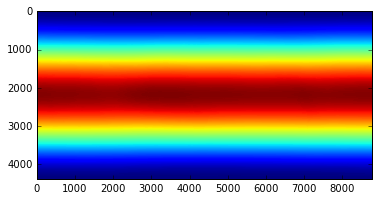

In [96]:
plt.imshow(grid)

This next function computes the distance from the North Pole on a sphere of radius $R_e$ to all points on a concentric sphere of radius $r_i$. 

Let $\theta$ = the co-latitude (ranging from 0 at the North Pole to $\pi$ at the South Pole).

Let $R_e$ be the radius of an external sphere with center at the origin. (The subscript e for either Earth or external...)

Let $r_i$ be the radius of an internal sphere concentric with the external one, with the vector ${\bf r}_i$ ending at an arbitrary point on the internal sphere. The length $|{\bf r}_i| = r_i$. We also assume that there is some mass located at ${\bf r}_i$. The distribution of these masses over all orientations of ${\bf r}_i$ and for all internal spheres is the object of our tomography. 

Let the $z$ axis be positive through the North Pole.

Let $r_a$ be the distance along the $z$ axis from the North Pole to the base of the vector perpendicular to the $z$ axis that ends at the position vector ${\bf r}_i$. Also let $r_b$ be the (perpendicular) distance from the $z$ axis to the position vector ${\bf r}_i$.

Finally, let $r_{pm}$ be the distance from the North Pole to a mass located at position vector ${\bf r}_i$.

Then $r_a = R_e - r_i \cos \theta$, $r_b = r_i \sin \theta$, and $r_{pm} = \sqrt{r_a^2 + r_b^2} = \sqrt{(R_e - r_i \cos \theta)^2 + (r_i \sin \theta)^2} = \sqrt{R_e^2 + r_i^2 - 2 r_i R_e \cos \theta}$.

In [4]:
def make_Rpm(R_e,r_i,co_lats,shp):
    rpm_1D = np.sqrt(-2.*r_i*R_e*np.cos(co_lats) + R_e**2 + r_i**2 )
    rpm_2D = np.zeros(shp,np.float32)
    rpm_2D[:,:] = rpm_1D[:,np.newaxis]
    
    return rpm_2D

In [7]:
grav = sht.MakeGravGridDH(coeffs,sht.constant.gm_earth,sht.constant.r0_pot_earth)

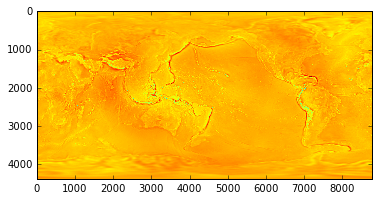

In [9]:
plt.imshow(grav[0])



**Old dead code only below here. Mostly preserved for examples of calling routines...**

In [ ]:
coeffs = sht.SHCoeffs.from_file('EGM2008_to2190_TideFree',2190)

In [8]:
sht.MakeGridDH?

In [40]:
sht.constant.r0_pot_earth

array(6378136.3)

In [15]:
grid.min()

-1.047208727436478e-05

In [92]:
r0_pot_earth = sht.constant.r0_pot_earth
gm_earth = sht.constant.gm_earth
w0_mars = sht.constant.w0_mars

print r0_pot_earth,gm_earth,w0_mars

6378136.3 3.986004415e+14 12654875.0


In [17]:
geoid = sht.MakeGeoidGridDH (coeffs, r0_pot_earth, gm_earth, grid.mean())

In [17]:
geoid.shape

(4382, 8764)

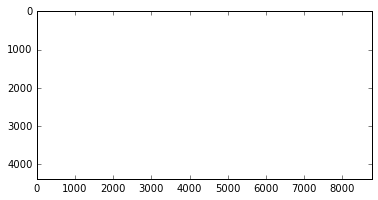

In [18]:
plt.imshow(geoid)

In [14]:
geoid.min()

nan

In [35]:
geoid.max()

nan

In [15]:
geoid.mean()

nan

In [19]:
sht.MakeGridDH?

In [3]:
print lmax

2190


In [6]:
co_lats = np.linspace(0.,np.pi,num=grid.shape[0],endpoint=True)

In [67]:
rpm_2D = -make_Rpm(R_e = r0_pot_earth, r_i = 0.9*r0_pot_earth, co_lats = co_lats, shp = grid.shape)

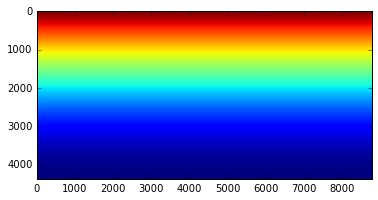

In [68]:
plt.imshow(rpm_2D)

In [11]:
class MyDHGrid(sht.classes.DHGrid):
    
    def __init__(self,array):
        self.nlat, self.nlon = array.shape
        if self.nlon == (2 * self.nlat):
            self.sampling = 2
        elif self.nlat == self.nlon:
            self.sampling = 1
        else:
            raise ValueError('input array with shape (nlat={:d},nlon={:d})\n' +
                             'it needs nlat=nlon or nlat=2*nlon'.format(self.nlat, self.nlon))
        self.data = array
        

rpm_dh2grid = MyDHGrid(rpm_2D)

In [9]:
%debug

> <ipython-input-8-78a40f7f5bd2>(11)__init__()
     10             raise ValueError('input array with shape (nlat={:d},nlon={:d})\n' +
---> 11                              'it needs nlat=nlon or nlat=2*nlon'.format(self.nlat, self.nlon))
     12         self.data = array

ipdb> p self.nlat
4382
ipdb> p 2*self.nlat
8764
ipdb> p self.nlon
8764
ipdb> q


In [69]:
rpm_2D_SH = sht.SHExpandDH(rpm_2D)

In [70]:
rpm_2D_SH.shape

(2, 2191, 2191)

In [71]:
coeffs.shape

(2, 2191, 2191)

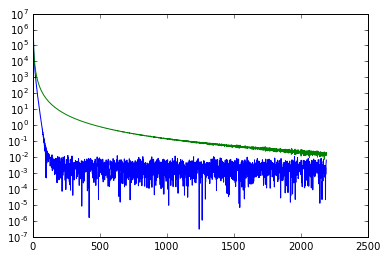

In [73]:
plt.semilogy(np.abs(rpm_2D_SH[0,:,0]))
plt.semilogy(np.abs(foo[0,:,0]))

In [74]:
convolved = rpm_2D_SH[0,:,0] * coeffs
print convolved.shape
convolved_c20 = convolved[0,2,0]
print convolved_c20
convolved[0,2,0] = 0.

(2, 2191, 2191)
3922.44199593


In [75]:
tomo_r1 = sht.MakeGridDH(convolved,sampling=2,csphase=1)

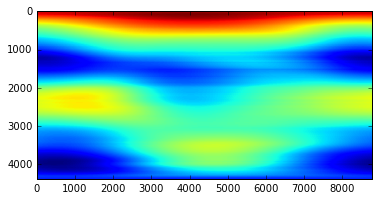

In [66]:
plt.imshow(tomo_r1)

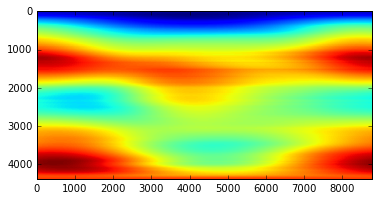

In [76]:
plt.imshow(tomo_r1)

In [87]:
ramp_filter = np.linspace(0.,1.,num=convolved.shape[1],endpoint=True)

cone_filter_2d = np.sqrt(np.outer(ramp_filter*ramp_filter,ramp_filter*ramp_filter))

In [88]:
filtered_convolved = cone_filter_2d[np.newaxis,:,:]* convolved

In [89]:
tomo_r1_filtered = sht.MakeGridDH(filtered_convolved,sampling=2,csphase=1)

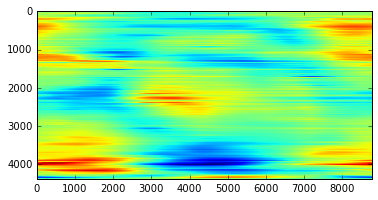

In [90]:
plt.imshow(tomo_r1_filtered)

In [101]:
omega = 2. * np.pi / (24.*60.*60.)
print omega
V_c = -(1./2.) * (omega**2) * (r0_pot_earth**2) * (np.sin(co_lats)**2)
print V_c.min()
print grid.max()

7.27220521664e-05
-107569.659005
0.000554780992829


In [102]:
print r0_pot_earth

6378136.3


In [105]:
G_Me = 3986004.415E8
Re_EGM08 = 6378136.3

In [ ]:
V_c_unitless = V_c*Re_EGM08/G_Me
V_c_u_
V_c_u_SH = sht.SHExpandDH(V_c_unitless)

In [108]:
V_c_unitless.min()

-0.0017212573681435323

In [110]:
print coeffs[0,2,0]

-0.000484165143791


In [115]:
no_cetrifugal_grid = grid + V_c_unitless[:,np.newaxis]

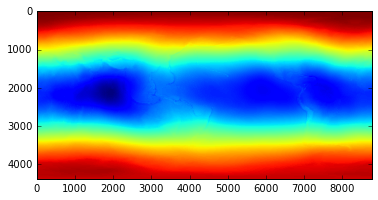

In [116]:
plt.imshow(no_cetrifugal_grid)